In [5]:
import os
import sys
from pathlib import Path

import torch
import matplotlib.pyplot as plt

from block.nn import layers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
root = Path(os.path.abspath("")).parent.parent

In [7]:
n_in = 10
n_out = 1
t_len = 100

torch.manual_seed(2)
single_spike_layer = layers.LinearNeurons(n_in, n_out, "fast_naive", t_len, beta_init=[0.9], single_spike=True)
single_spike_layer.init_weight(single_spike_layer._to_current.weight, "constant", c=1)

In [8]:
def get_input_spikes(thresh=0.595, multi=True):
    torch.manual_seed(0)
    input_spikes = 0.6*torch.rand(n_in, t_len)
    input_spikes[input_spikes > thresh] = 1
    input_spikes[input_spikes < 1] = 0 
    
    if not multi:
        input_spikes *= 0
        input_spikes[0, 23] = 1
        input_spikes[1, 62] = 1
        input_spikes[2, 50] = 1
    
    return input_spikes

def get_unit_and_spike_times(spikes):
    n_units, n_steps = spikes.shape
    
    x = []
    y = []
    
    for n in range(n_units):
        for t in range(n_steps):
            if spikes[n, t] == 1:
                x.append(t)
                y.append(n)
                
    return x, y

input_spikes = get_input_spikes(multi=True)

In [9]:
with torch.no_grad():
    spikes, z, faulty_spikes, membrane, current = single_spike_layer(input_spikes.unsqueeze(0), return_type=2)
    spikes = spikes[0, 0]
    faulty_spikes = faulty_spikes[0, 0, 0]
    z = z[0, 0, 0]
    membrane = membrane[0, 0]
    current = current[0, 0]
    input_time_idx, input_unit_idx = get_unit_and_spike_times(input_spikes)
    faulty_time_idx, _ = get_unit_and_spike_times(faulty_spikes.unsqueeze(0))
    output_time_idx, _ = get_unit_and_spike_times(spikes.unsqueeze(0))

In [10]:
def plot_activity(z, mem, current, intput_time_idx, input_unit_idx, faulty_time_idx, output_time_idx):
    fig, axs = plt.subplots(6, 1, constrained_layout = True, figsize=(8, 4), gridspec_kw={'height_ratios': [0.5, 1.5, 0.5, 3, 1.5, 2]})
    
    linewidth = 2.5
    dot_size = 25
    
    for ax in axs:
        ax.set_xticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(linewidth)
        ax.spines["bottom"].set_linewidth(linewidth)
        ax.set_xlim([0, t_len])
        ax.yaxis.set_tick_params(width=linewidth, length=5)
        ax.xaxis.set_tick_params(width=linewidth, length=5)
        #ax.set_yticks([0, 1])
        ax.tick_params(axis="both", which="major", pad=5, labelsize=15) 
    
    dt = 0.4
    
    axs[0].scatter(output_time_idx, [[0.5] * len(output_time_idx)], s=dot_size)
    axs[0].set_ylabel("$S$", fontsize=20, labelpad=28)
    axs[0].set_ylim([0, 1])
    axs[0].set_yticks([])
    axs[0].spines["left"].set_visible(False)
    
    axs[1].plot(z, linewidth=1.5)
    axs[1].set_ylabel("$z$", fontsize=20, labelpad=5)
    axs[1].set_ylim([0, z.max()])
    #axs[1].set_yticks([0, z.max()])
    axs[1].set_yticklabels([0, "3k"])
    #axs[1].set_yticks([0, "3k"])
    
    axs[2].scatter(faulty_time_idx, [[0.5] * len(faulty_time_idx)], s=dot_size)
    axs[2].set_ylabel("$\\tilde{S}$", fontsize=20, labelpad=23)
    axs[2].set_ylim([0, 1])
    axs[2].set_yticks([])
    axs[2].spines["left"].set_visible(False)
    
    axs[3].plot(mem, linewidth=3.0)
    axs[3].set_ylabel("$\\tilde{V}$", fontsize=20, labelpad=5)
    axs[3].set_ylim([0-dt, mem.max()+dt])
    axs[3].set_yticks([0, int(mem.max())])
    #axs[3].plot([0, t_len], [1, 1], ":", c="gray", linewidth=linewidth)
    
    axs[4].plot(current, linewidth=3.0)
    axs[4].set_ylabel("$I$", fontsize=20, labelpad=9)
    axs[4].set_ylim([0-dt, current.max()+dt])
    
    axs[5].scatter(input_time_idx, input_unit_idx, s=dot_size, c="black")
    #axs[5].set_ylabel("$S$", fontsize=20, labelpad=5)
    axs[5].spines["bottom"].set_visible(False)
    axs[5].spines["bottom"].set_linewidth(linewidth)
    axs[5].spines["left"].set_visible(False)
    axs[5].xaxis.set_tick_params(width=0, length=5)
    axs[5].set_xticks([0, t_len])
    axs[5].set_ylim([-1, n_in])
    axs[5].tick_params(axis="both", which="major", pad=5, labelsize=15) 
    axs[5].set_yticks([])
    axs[5].set_xticklabels([0, t_len])
    axs[5].set_xlabel("Time (ms)", fontsize=15, labelpad=0)
    
    fig.tight_layout()
    return axs

/tmp/ipykernel_125545/3847753278.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([0, "3k"])
/tmp/ipykernel_125545/3847753278.py:64: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


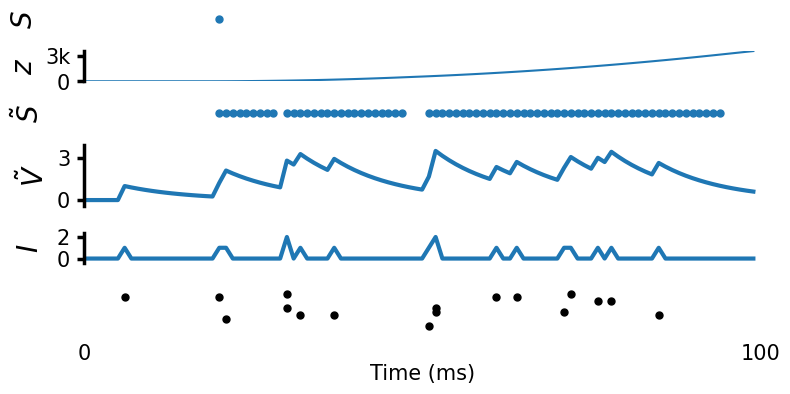

In [11]:
plot_activity(z, membrane, current, input_time_idx, input_unit_idx, faulty_time_idx, output_time_idx)
plt.savefig(f"{root}/figures/figure2.svg", dpi=300, bbox_inches="tight")